In [612]:
import pandas as pd
import numpy as np

In [613]:
judul = 'Yearly Average IDX COMPOSITE (^JKSE) Price'

data1 = pd.read_csv("C:\\Users\\untu0\\OneDrive - Bina Nusantara\\Binus\\Semester 4 DS\\research\\proyek\\Jakarta Stock Exchange LQ45 Historical Data.csv")

data1['Date'] = pd.to_datetime(data1['Date'])

# Mengurutkan data berdasarkan tanggal
data1 = data1.sort_values(by='Date')

#Menghilangkan koma pada ribuan
data1['Price'] = data1['Price'].str.replace(',', '').astype(float)
data1['Open'] = data1['Open'].str.replace(',', '').astype(float)
data1['High'] = data1['High'].str.replace(',', '').astype(float)
data1['Low'] = data1['Low'].str.replace(',', '').astype(float)
date = data1['Date']
# set index pada Date
df = data1.set_index('Date')

df.head()


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,984.35,983.58,986.57,980.21,1.14B,0.16%
2019-01-03,990.88,983.09,990.88,981.16,1.29B,0.66%
2019-01-04,1001.64,988.40,1001.64,985.94,1.98B,1.09%
2019-01-07,1002.78,1012.40,1017.83,1002.78,2.61B,0.11%
2019-01-08,997.42,1004.04,1008.43,994.01,1.77B,-0.53%


In [614]:
df.isna().mean()*100

Price       0.000000
Open        0.000000
High        0.000000
Low         0.000000
Vol.        0.235294
Change %    0.000000
dtype: float64

In [615]:
forecast_days = 30
df = df[['Price']]
df['Prediction'] = df[['Price']].shift(-forecast_days)
df

,Price,Prediction
Date,,
2019-01-02,984.35,1000.77
2019-01-03,990.88,994.97
2019-01-04,1001.64,1017.81
2019-01-07,1002.78,1013.95
2019-01-08,997.42,1019.33
...,...,...
2024-03-19,997.15,NaN
2024-03-20,992.93,NaN
2024-03-21,994.77,NaN


In [616]:
df.isna().sum()

Price          0
Prediction    30
dtype: int64

In [617]:
X = np.array(df.drop(columns='Prediction'))
X = X[:-forecast_days]
y = np.array(df['Prediction'])
y = y[:-forecast_days]

In [618]:
split = int(0.8* len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


In [619]:
from sklearn.svm import SVR

In [620]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000,10000],
    'gamma': [3,2,1, 0.1, 0.01, 0.005, 0.001,0.0005],
}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='max_error')
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

print("Best SVR Model:")
print("Best Parameters:", grid_search.best_params_)


Best SVR Model:
Best Parameters: {'C': 1, 'gamma': 0.0005}


In [621]:
best_params = grid_search.best_params_
C_best = best_params['C']
gamma_best = best_params['gamma']

model = SVR(kernel='rbf', C=C_best, gamma=gamma_best)
model.fit(X_train, y_train)

SVR(C=1, gamma=0.0005)

In [622]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
r2score = r2_score(y_test,y_pred)
print("mae = ", mae)
print("mse = ", mse)
print("r2_score = ", r2score)

mae =  20.66292093431273
mse =  719.8232515388803
r2_score =  -0.1400988373473795


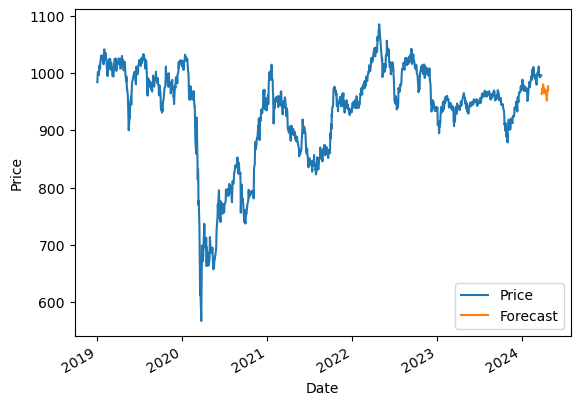

In [623]:
forecast_set = model.predict(X[-forecast_days:])
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = pd.Timestamp(next_unix, unit='s')
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
df['Price'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [624]:
date_forecast = df.reset_index()
real_price = df['Price']
date = date_forecast['Date']
date_train,date_test = date[:len(y_train)], date[len(y_train):]
price_train ,price_test = real_price[:len(y_train)], real_price[len(y_train):]
forecasting = df['Forecast'].dropna()

In [625]:
len(y_pred)

249

In [626]:
target_length  = len(date_test)-30
date_test = date_test[:-30]
y_test = np.append(y_test, [np.nan] * (target_length - len(y_test)))
y_pred = np.append(y_pred, [np.nan] * (target_length - len(y_pred)))
forecast = np.concatenate(([np.nan] * (target_length - len(forecasting)), forecasting))

new_dataframe = pd.DataFrame({
    'Date': date_test,
    'Actual': y_test,
    'Predicted': y_pred,
    'Forecasting': forecast
})
plot = new_dataframe.set_index('Date')

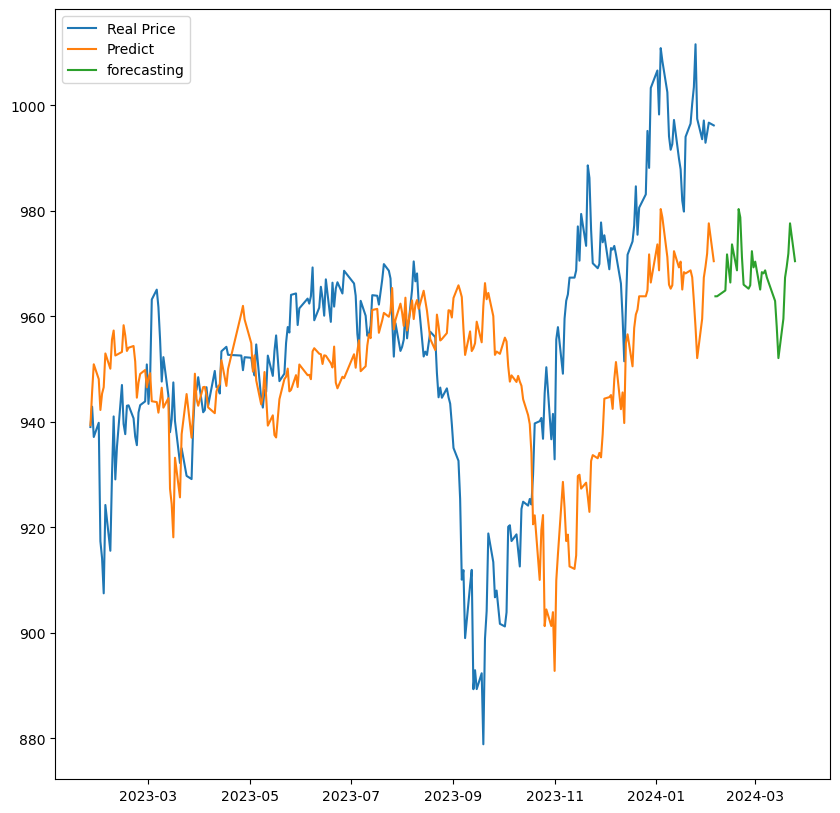

In [627]:
plt.figure(figsize=[10,10])
plt.plot(plot)
plt.legend(['Real Price',"Predict", "forecasting"])